In [201]:
import matplotlib.pyplot as plt
import matplotlib
import requests
import re
import pandas as pd
import sys
import warnings
import numpy as np
import fbprophet
import datetime
import dateutil.parser
from bs4 import BeautifulSoup
from six import string_types

warnings.filterwarnings('ignore')
%matplotlib inline 

In [202]:
"""
This has been implement with the help of Stocker.
Statistically this isn't significant but was useful
to show the absolute power for Facebook's fbprophet.
"""

class Forecaster:

    _BASE_URL = "https://www.hockey-reference.com"

    ###########
    # Constructor
    ###########
    def __init__(self, player, player_abbr, y):
        self.player = player
        self.player_abbr = player_abbr
        self.goalie = False
        
        self.y = y
        
        self.player_log = self._get_training_data(self.player, self.player_abbr, y)
        self.player_log = self.player_log.reset_index(level=0) # Set the index to a column called Date
        # Minimum and maximum date in range
        self.min_date = min(self.player_log['DATE'])
        self.max_date = max(self.player_log['DATE'])
        
        print(f"min_date={self.min_date} max_date={self.max_date}")

        # Find max and min fantasy points and days on which they occurred
        self.max_y = np.max(self.player_log[self.y])
        self.min_y = np.min(self.player_log[self.y])
        print(f"max_y={self.max_y} min_y={self.min_y}")
        self.min_y_date = self.player_log[self.player_log[self.y] == self.min_y]['DATE']
        self.min_y_date = self.min_y_date[self.min_y_date.index[0]]
        self.max_y_date = self.player_log[self.player_log[self.y] == self.max_y]['DATE']
        self.max_y_date = self.max_y_date[self.max_y_date.index[0]]
        print(f"min_y_date={self.min_y_date} max_y_date={self.max_y_date}")
        # The most recent fantasy points scored
        #self.most_recent_dfs_points = self.player_log.ix[len(self.player_log)-1, 'DK']
        self.most_recent = self.player_log[self.y].iloc[-1]
        print(f"most_recent={self.most_recent}")
        # Number of years of data to train on
        self.training_years = 3

        # Prophet parameters
        # Default prior from library
        self.changepoint_prior_scale = 0.05 
        self.weekly_seasonality = False
        self.daily_seasonality = False
        self.monthly_seasonality = True
        self.yearly_seasonality = True
        self.changepoints = None
        self.interval_width = 0.95
        self.seasonality_mode = 'additive'
        self.growth = 'linear'
        self.cap = 80.
        self.floor = 10.
        
        print('{} Forecaster Initialized. Data covers {} to {}.'.format(self.player,
                                                                     self.min_date.date(),
                                                                     self.max_date.date()))
        
    #############
    # This will simulate a static variable.
    #############
    @property
    def BASE_URL(self):
        return self._BASE_URL

    
    ###########
    # Return the dataframe trimmed to the specified range.
    ###########
    def make_df(self, start_date, end_date, df=None):
        
        # Default is to use the object player data
        if not df:
            df = self.player_log.copy()
            
        # Validate whether start and end dates are in data
        start_in = True
        end_in = True
        
        # Record if start and end dates are in dataframe
        if (start_date not in list(df['DATE'])):
            start_in = False
        if (end_date not in list(df['DATE'])):
            end_in = False

        print(f"start_date={start_date} end_date={end_date}")
        print(f"end_in={end_in} start_in={start_in}")      
        # If both are NOT in data, round both
        if (not end_in) & (not start_in):
            trim_df = df[(df['DATE'] >= start_date.date()) & 
                         (df['DATE'] <= end_date.date())]
        else:
            # If both are in dataframe, round neither
            if (end_in) & (start_in):
                trim_df = df[(df['DATE'] >= start_date.date()) & 
                             (df['DATE'] <= end_date.date())]
            else:
                # If only start is missing, round start
                if (not start_in):
                    trim_df = df[(df['DATE'] > start_date.date()) & 
                                 (df['DATE'] <= end_date.date())]
                # If only end is imssing round end
                elif (not end_in):
                    trim_df = df[(df['DATE'] >= start_date.date()) & 
                                 (df['DATE'] < end_date.date())]
        return trim_df
        
    ##########
    # Basic Historical Plots and Statistics
    ##########   
    def plot_points(self, start_date=None, end_date=None, stats=['CORE'], plot_type='basic'):
        
        self.reset_plot()

        if start_date == None:
            start_date = self.min_date
        if end_date == None:
            end_date = self.max_date
            
        points_plot = self.make_df(start_date, end_date)
        
        colors = ['r', 'b', 'g', 'y', 'c', 'm']
        
        for i, stat in enumerate(stats):
            
            stat_min = min(points_plot[stat])
            stat_max = max(points_plot[stat])

            stat_avg = np.mean(points_plot[stat])
            date_stat_min = points_plot[points_plot[stat] == stat_min]['DATE']
            date_stat_min = date_stat_min[date_stat_min.index[0]]
            date_stat_max = points_plot[points_plot[stat] == stat_max]['DATE']
            date_stat_max = date_stat_max[date_stat_max.index[0]]
            
            #self.player_log['DK'].iloc[-1]
            print('Maximum {} = {:.2f} on {}.'.format(stat, stat_max, date_stat_max.date()))
            print('Minimum {} = {:.2f} on {}.'.format(stat, stat_min, date_stat_min.date()))
            print('Current {} = {:.2f} on {}.\n'.format(stat, self.player_log[stat].iloc[-1], self.max_date.date()))
            
            # Percentage y-axis
            if plot_type == 'pct':
                # Simple Plot 
                plt.style.use('fivethirtyeight');
                
                if stat == 'Daily Change':
                    plt.plot(points_plot['DATE'], 100 * points_plot[stat],
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)
                else:
                    plt.plot(points_plot['DATE'], 100 * (points_plot[stat] -  stat_avg) / stat_avg,
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)

                plt.xticks(rotation='vertical')
                plt.xlabel('Date') 
                plt.ylabel('Change Relative to Average (%)') 
                plt.title('%s Points History' % self.player); 
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4); 

            # Stat y-axis
            elif plot_type == 'basic':
                plt.style.use('fivethirtyeight');
                plt.plot(points_plot['DATE'], points_plot[stat], color = colors[i], linewidth = 3, label = stat, alpha = 0.8)
                plt.xticks(rotation='vertical')
                plt.xlabel('DATE')
                plt.ylabel(' '.join(stats))
                plt.title('%s Points History' % self.player) 
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4); 
      
        plt.show();
        
    ##########
    # Reset the plotting parameters to clear style formatting
    # Not sure if this should be a static method
    ##########
    @staticmethod
    def reset_plot():
        
        # Restore default parameters
        matplotlib.rcParams.update(plt.rcParamsDefault)

        # Adjust a few parameters to liking
        matplotlib.rcParams['figure.figsize'] = (8, 5)
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 14
        matplotlib.rcParams['text.color'] = 'k'

    #########
    # private function to fetch training data
    #########
    def _get_training_data(self, player, extension, y):
        letter = extension[:1]
        player_url = f"{self.BASE_URL}/players/{letter}/{extension}.html"

        print("getting training data for " + player + " ...")
        print(player_url)

        # Follow the URL and extract the additional data needed
        r = requests.get(player_url, verify=False)

        b = BeautifulSoup(r.text, "html.parser")
        
        uls = b.find_all("ul")

        game_logs = {}

        for ul in uls:
            a = ul.find_all("a", href=True)
            for link in a:
                # regex = ".*/gamelog/(2017|2018|2019)"
                regex = ".*/gamelog/(2017|2018|2019)"    
                if re.search(regex, link['href']):
                    if re.search(".*/2016", link['href']):
                        season = 2016
                    elif re.search("./2017", link['href']):
                        season = 2017
                    elif re.search("./2018", link['href']):
                        season = 2018
                    elif re.search("./2019", link['href']):
                        season = 2019
                    value = link['href']
                    key = season
                    game_logs[key]=value

            player_log = pd.DataFrame()
            
        for key in game_logs:
            url = f"{self.BASE_URL}{game_logs[key]}"
            try:
                print(f"url={url} key={key} player={player} goalie={self.goalie}")
                buffer_df = self._get_log_data(self, url, key, player, self.goalie)
                player_log = player_log.append(buffer_df)
            except Exception :
                print(f"Unexpected error: {sys.exc_info()[0]}")
                print("ERROR: This is not an active player.")
                buffer_df = pd.DataFrame()
                break
        if not self.goalie:
            try:
                player_log.BLK[player_log.BLK == ''] = 0
            except:
                pass
            
        player_log = player_log.apply(pd.to_numeric, downcast='float', errors='ignore')
        player_log.fillna(0.0, inplace=True)
        player_log['DATE'] = pd.to_datetime(player_log['DATE'].apply(self.convert_to_date))
        player_log['ds'] = player_log['DATE']
        player_log['DK'] = player_log.apply(self._calculate_draftkings_score, axis=1)
        player_log['CORE'] = player_log.apply(self._calculate_core_points, axis=1)
        # This is needed for modeling.
        player_log['y'] = player_log[y]
        player_log['TOI_CONV'] = player_log.apply(self._convert_total_on_ice, axis=1)
        player_log['ESP_PG'] = (player_log['EV_G'].astype(float) + player_log['EV_A'].astype(float)) / 60.0
        player_log['PPP_PG'] = (player_log['PP_G'].astype(float) + player_log['PP_A'].astype(float)) / 60.0
        player_log['PPG'] = (player_log.PTS/player_log.TOI_CONV) * 60
        
        return player_log

    @staticmethod
    def convert_to_date(value):
        if isinstance(value, string_types) and re.search(r'^\d{4}-\d{2}-\d{2}$', value):
            return dateutil.parser.parse(value).date()
        elif isinstance(value, string_types) and re.search(r'^\d{4}-\d{2}-\d{2}T[\d:\.]+Z$', value):
            # convert to datetime.datetime, default timezone is utc
            return dateutil.parser.parse(value)
        else:
            return value
    
    ############
    # Convert string for total on ice to time
    ############
    @staticmethod
    def _convert_total_on_ice(row):
        t = row.TOI
        m, s = t.split(':')

        return float((int(m) * 1) + (int(s)/60))
    """
    Point Scoring

    Points will be scored in the same way for all DraftKings daily fantasy hockey contests, according to the following schedule:

    Goal Scored: 3 Points
    Assist: 2 Points
    Shot on Goal: 0.5 Points
    Blocked Shot: 0.5 Points
    Short Handed Point Bonus (Goal/Assist): 1 Points
    Shootout Goal: 0.2 Points
    Hat Trick Bonus: 1.5 Points

    In addition, goalies will score points for the following actions:

    Team Win: +3 Points
    Save: +0.2 Points
    Goal Allowed: -1 Points
    Shutout Bonus: +2 Points
    """
    @staticmethod
    def _calculate_draftkings_score(row):
        hat_trick_bonus = 0.0
        if row.G >= 3.0:
            hat_trick_bonus = 1.5
        return (row.G * 3.0) + (row.A * 2.0) + (row.S * 0.5) + (row.BLK * 0.5) + (row.SH_G * 1.0) + (row.SH_A + 1.0) + hat_trick_bonus
    
    ###########
    # Calcuate points for core scoring, removing bonuses
    ###########
    @staticmethod
    def _calculate_core_points(row):
        return (row.G * 3.0) + (row.A * 2.0) + (row.S * 0.5) + (row.BLK * 0.5)
    
    ###########
    # Private method to scrape game log data
    ###########
    @staticmethod
    def _get_log_data(self, gamelogs_url, season, player, goalie):
        url = gamelogs_url
        r = requests.get(url, verify=False)
        b = BeautifulSoup(r.text, "html.parser")
        
        # Find tables tagged with id=gamelogs
        table = b.find_all('table', {'id': 'gamelog'})
        rows = []
        for tbl in table:
            for tr in tbl.find_all('tr'):
                row = []
                for td in tr.find_all('td'):
                    row.append(td.text.replace('\n',''))
                if not goalie:
                    if len(row) == 28 and row[0] != "":
                        rows.append(row)
                else:
                    if len(row) == 15 and row[0] != "":
                        rows.append(row)
        if not goalie:
            log_data = pd.DataFrame(rows, columns=['DATE', 'GAME', 'AGE', 'TM', 'HOA',
                                                'OPP', 'RSLT', 'G', 'A', 'PTS',
                                                'PM', 'PIM', 'EV_G', 'PP_G',
                                                'SH_G', 'GW_G', 'EV_A', 'PP_A',
                                                'SH_A', 'S', 'S_PCT', 'SHFT',
                                                'TOI', 'HIT', 'BLK', 'FOW',
                                                'FOL', 'FO_PCT'])
        else:
            log_data = pd.DataFrame(rows, columns=['DATE', 'GAME', 'AGE', 'TM', 'HOA',
                                                'OPP', 'RSLT', 'DEC', 'GA', 'SA', 
                                                'SV', 'SV_PCT', 'SO', 'PIM', 'TOI'])

        log_data['season'] = season
        log_data['name'] = player
        log_data.head()
        return log_data
    
    #############
    # Create a prophet model without training
    #############
    def create_model(self):
        
        # Make the model
        model = fbprophet.Prophet(daily_seasonality=self.daily_seasonality,
                                 weekly_seasonality=self.weekly_seasonality,
                                 yearly_seasonality=self.yearly_seasonality,
                                 changepoint_prior_scale=self.changepoint_prior_scale,
                                 changepoints=self.changepoints,
                                 interval_width=self.interval_width,
                                 seasonality_mode=self.seasonality_mode,
                                 growth=self.growth)
        if self.monthly_seasonality:
            # Add monthly seasonality
            model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
            
        return model
    
    #############
    # Basic prophet model for specified number of days  
    #############
    def create_prophet_model(self, days=0, resample=False):
        
        self.reset_plot()
        
        model = self.create_model()
        
        # Fit on point history for self.training_year number of years
        point_history = self.player_log[self.player_log['DATE'] > (self.max_date - pd.DateOffset(years=self.training_years)).date()]
        if self.growth == 'logistic':
            point_history['cap'] = self.cap
            point_history['floor'] = self.floor
        model.fit(point_history)
        
        future = model.make_future_dataframe(periods=days, freq='D')
        if self.growth == 'logistic':
            future['cap'] = self.cap
            future['floor'] = self.floor
        future = model.predict(future)
        
        if days > 0:
            # Print the predicted points
            print('Predicted Points on {} = {:.2f}'.format(
                future.ix[len(future) - 1, 'ds'].date(), future.ix[len(future) - 1, 'yhat']))

            title = '%s Historical and Predicted Points'  % self.player
        else:
            title = '%s Historical and Modeled Points' % self.player
            
        # Set up the plot
        fig, ax = plt.subplots(1, 1)

        # Plot the actual values
        ax.plot(point_history['ds'], point_history['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
        
        # Plot the predicted values
        ax.plot(future['ds'], future['yhat'], 'forestgreen',linewidth = 2.4, label = 'Modeled');

        # Plot the uncertainty interval as ribbon
        ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.3, 
                       facecolor = 'g', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 10}); plt.xlabel('Date'); plt.ylabel(self.y);
        plt.grid(linewidth=0.6, alpha = 0.6)
        plt.title(title);
        plt.show()
        
        return model, future
    
    ##############
    # Evalue prediction model for 1 year
    ##############
    def evaluate_prediction(self, start_date=None, end_date=None, nshares=None):
        # Default start date is one year before end of data
        # Default end date is end date of data
        if start_date is None:
            start_date = self.max_date - pd.DateOffset(years=1)
        if end_date is None:
            end_date = self.max_date
            
        # Training data starts self.training_years years before start_date and goes up to start date
        train = self.player_log[(self.player_log['DATE'] < start_date.date()) &
                               (self.player_log['DATE'] > (start_date - pd.DateOffset(years=self.training_years)).date())]
        
        # Testing data is specified in the range
        test = self.player_log[(self.player_log['DATE'] >= start_date.date()) & (self.player_log['DATE'] <= end_date.date())]
        
        # Create and train the model
        model = self.create_model()
        # This is needed if the algo is Logistic
        if self.growth == 'logistic':
            train['cap'] = self.cap
            train['floor'] = self.floor
        model.fit(train)
        
        # Make a future dataframe and predictions
        future = model.make_future_dataframe(periods = 365, freq='D')
        # This is needed if the algo is Logistic
        if self.growth == 'logistic':
            future['cap'] = self.cap
            future['floor'] = self.floor
        future = model.predict(future)
        
        # Merge predictions with the known values
        test = pd.merge(test, future, on = 'ds', how = 'inner')

        train = pd.merge(train, future, on = 'ds', how = 'inner')
        
        # Calculate the differences between consecutive measurements
        test['pred_diff'] = test['yhat'].diff()
        test['real_diff'] = test['y'].diff()
        
        # Correct is when we predicted the correct direction
        test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1
        
        # Accuracy when we predict increase and decrease
        increase_accuracy = 100 * np.mean(test[test['pred_diff'] > 0]['correct'])
        decrease_accuracy = 100 * np.mean(test[test['pred_diff'] < 0]['correct'])

        # Calculate mean absolute error
        test_errors = abs(test['y'] - test['yhat'])
        test_mean_error = np.mean(test_errors)

        train_errors = abs(train['y'] - train['yhat'])
        train_mean_error = np.mean(train_errors)

        # Calculate percentage of time actual value within prediction range
        test['in_range'] = False

        for i in test.index:
            if (test.ix[i, 'y'] < test.ix[i, 'yhat_upper']) & (test.ix[i, 'y'] > test.ix[i, 'yhat_lower']):
                test.ix[i, 'in_range'] = True

        in_range_accuracy = 100 * np.mean(test['in_range'])
        
        if not nshares:

            # Date range of predictions
            print('\nPrediction Range: {} to {}.'.format(start_date.date(),
                end_date.date()))

            # Final prediction vs actual value
            print('\nPredicted points on {} = {:.2f}.'.format(max(future['ds']).date(), future.ix[len(future) - 1, 'yhat']))
            print('Actual points on    {} = {:.2f}.\n'.format(max(test['ds']).date(), test.ix[len(test) - 1, 'y']))

            print('Average Absolute Error on Training Data = {:.2f}.'.format(train_mean_error))
            print('Average Absolute Error on Testing  Data = {:.2f}.\n'.format(test_mean_error))

            # Direction accuracy
            print('When the model predicted an increase, the points increased {:.2f}% of the time.'.format(increase_accuracy))
            print('When the model predicted a  decrease, the points decreased  {:.2f}% of the time.\n'.format(decrease_accuracy))

            print('The actual value was within the {:d}% confidence interval {:.2f}% of the time.'.format(int(100 * model.interval_width), in_range_accuracy))


             # Reset the plot
            self.reset_plot()
            
            # Set up the plot
            fig, ax = plt.subplots(1, 1)

            # Plot the actual values
            ax.plot(train['ds'], train['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
            ax.plot(test['ds'], test['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
            
            # Plot the predicted values
            ax.plot(future['ds'], future['yhat'], 'navy', linewidth = 2.4, label = 'Predicted');

            # Plot the uncertainty interval as ribbon
            ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.6, 
                           facecolor = 'gold', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

            # Put a vertical line at the start of predictions
            plt.vlines(x=min(test['ds']).date(), ymin=min(future['yhat_lower']), ymax=max(future['yhat_upper']), colors = 'r',
                       linestyles='dashed', label = 'Prediction Start')

            # Plot formatting
            plt.legend(loc = 2, prop={'size': 8}); plt.xlabel('Date'); plt.ylabel(self.y);
            plt.grid(linewidth=0.6, alpha = 0.6)
                       
            plt.title('{} Model Evaluation from {} to {}.'.format(self.player,
                start_date.date(), end_date.date()));
            plt.show();
            
    ##############
    # Predict the future result for a given range of days
    ##############
    def predict_future(self, days=30):
        
        #Use self.training_years for training length
        train = self.player_log[self.player_log['DATE'] > (max(self.player_log['DATE'])
                                                          - pd.DateOffset(years=self.training_years)).date()]
        
        if self.growth == 'logistic':
            train['cap'] = self.cap
            train['floor'] = self.floor
        
        model = self.create_model()
        model.fit(train)
        
        # Future dataframe with specified number of days to predict
        future = model.make_future_dataframe(periods=days, freq='D')
        if self.growth == 'logistic':
            future['cap'] = self.cap
            future['floor'] = self.floor
        future = model.predict(future)
        
        # We are only concerned about future dates
        future = future[future['ds'] >= max(self.player_log['DATE']).date()]
        
        # Calculate whether increase or not
        future['diff'] = future['yhat'].diff()
        
        future = future.dropna()
        
        # Find the prediction direction and create separate dataframes
        future['direction'] = (future['diff'] > 0) * 1
        
        # Rename the columns for presentation
        future = future.rename(columns={'ds': 'Date', 'yhat': 'estimate', 'diff': 'change', 
                                        'yhat_upper': 'upper', 'yhat_lower': 'lower'})
        
        future_increase = future[future['direction'] == 1]
        future_decrease = future[future['direction'] == 0]
        
        # Print out the dates
        print('\nPredicted Increase: \n')
        print(future_increase[['Date', 'estimate', 'change', 'upper', 'lower']])
        
        print('\nPredicted Decrease: \n')
        print(future_decrease[['Date', 'estimate', 'change', 'upper', 'lower']])
        
        self.reset_plot()
        
        # Set up plot
        plt.style.use('fivethirtyeight')
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 12
        
        # Plot the predictions and indicate if increase or decrease
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the estimates
        ax.plot(future_increase['Date'], future_increase['estimate'], 'g^', ms = 12, label = 'Pred. Increase')
        ax.plot(future_decrease['Date'], future_decrease['estimate'], 'rv', ms = 12, label = 'Pred. Decrease')
        
        # Plot errorbars
        ax.errorbar(future['Date'].dt.to_pydatetime(), future['estimate'], 
                    yerr = future['upper'] - future['lower'], 
                    capthick=1.4, color = 'k',linewidth = 2,
                   ecolor='darkblue', capsize = 4, elinewidth = 1, label = 'Pred with Range')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 10});
        plt.xticks(rotation = '45')
        plt.ylabel(f"Predicted {self.y}")
        plt.xlabel('Date'); plt.title('Predictions for %s' % self.player)
        plt.show()
        
    #############
    # Changepoint date analysis
    #############
    def changepoint_date_analysis(self):
        self.reset_plot()
        
        model = self.create_model()
        
        #Use self.training_years for training length
        train = self.player_log[self.player_log['DATE'] > (max(self.player_log['DATE'])
                                                          - pd.DateOffset(years=self.training_years)).date()]
        if self.growth == 'logistic':
            train['cap'] = self.cap
            train['floor'] = self.floor
        model.fit(train)
        
        future = model.make_future_dataframe(periods=0, freq='D')
        if self.growth == 'logistic':
            future['cap'] = self.cap
            future['floor'] = self.floor
        future = model.predict(future)
        
        train = pd.merge(train, future[['ds', 'yhat']], on='ds', how='inner')
        
        changepoints = model.changepoints
        train = train.reset_index(drop=True)
        
        # Create dataframe of only changepoints
        change_indicies = []
        for changepoint in (changepoints):
            change_indicies.append(train[train['ds'] == changepoint.date()].index[0])
            
        c_data = train.ix[change_indicies, :]
        deltas = model.params['delta'][0]
        
        c_data['delta'] = deltas
        c_data['abs_delta'] = abs(c_data['delta'])
        
        # Sort by maximum change
        c_data = c_data.sort_values(by='abs_delta', ascending=False)
        
        # Limit to 10 biggest
        c_data = c_data[:10]
        
        # Separate into negative and positive changepoints
        cpos_data = c_data[c_data['delta'] > 0]
        cneg_data = c_data[c_data['delta'] < 0]

        # Changepoints and data
        print('\nChangepoints sorted by slope rate of change (2nd derivative):\n')
        print(c_data.ix[:, ['DATE', 'DK', 'delta']][:5])

        # Line plot showing actual values, estimated values, and changepoints
        self.reset_plot()

        # Set up line plot 
        plt.plot(train['ds'], train['y'], 'ko', ms = 4, label = self.y)
        plt.plot(future['ds'], future['yhat'], color = 'navy', linewidth = 2.0, label = 'Modeled')

        # Changepoints as vertical lines
        plt.vlines(cpos_data['ds'].dt.to_pydatetime(), ymin = min(train['y']), ymax = max(train['y']), 
                   linestyles='dashed', color = 'r', 
                   linewidth= 1.2, label='Negative Changepoints')

        plt.vlines(cneg_data['ds'].dt.to_pydatetime(), ymin = min(train['y']), ymax = max(train['y']), 
                   linestyles='dashed', color = 'darkgreen', 
                   linewidth= 1.2, label='Positive Changepoints')

        plt.legend(prop={'size':10});
        plt.xlabel('Date'); plt.ylabel('Price ($)'); plt.title(f"{self.y} with Changepoints")
        plt.show()
        
    ##############
    # Changepoint prior validation
    ##############
    def changepoint_prior_validation(self, start_date=None, end_date=None,changepoint_priors = [0.001, 0.05, 0.1, 0.2]):


        # Default start date is two years before end of data
        # Default end date is one year before end of data
        if start_date is None:
            start_date = self.max_date - pd.DateOffset(years=2)
        if end_date is None:
            end_date = self.max_date - pd.DateOffset(years=1)
            
        # Convert to pandas datetime for indexing dataframe
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        # Select self.training_years number of years
        train = self.player_log[(self.player_log['DATE'] > (start_date - pd.DateOffset(years=self.training_years)).date()) & 
        (self.player_log['DATE'] < start_date.date())]
        
        if self.growth == 'logistic':
            train['cap'] = self.cap
            train['floor'] = self.floor
        
        
        # Testing data is specified by range
        test = self.player_log[(self.player_log['DATE'] >= start_date.date()) & (self.player_log['DATE'] <= end_date.date())]
        
        if self.growth == 'logistic':
            test['cap'] = self.cap
            test['floor'] = self.floor
            
        eval_days = (max(test['DATE']).date() - min(test['DATE']).date()).days
        
        results = pd.DataFrame(0, index = list(range(len(changepoint_priors))), 
            columns = ['cps', 'train_err', 'train_range', 'test_err', 'test_range'])

        print('\nValidation Range {} to {}.\n'.format(min(test['DATE']).date(),
            max(test['DATE']).date()))
        
        # Iterate through all the changepoints and make models
        for i, prior in enumerate(changepoint_priors):
            results.ix[i, 'cps'] = prior
            
            # Select the changepoint
            self.changepoint_prior_scale = prior
            
            # Create and train a model with the specified cps
            model = self.create_model()
            model.fit(train)
            future = model.make_future_dataframe(periods=eval_days, freq='D')
            
            if self.growth == 'logistic':
                future['cap'] = self.cap
                future['floor'] = self.floor
            
            future = model.predict(future)
            
            # Training results and metrics
            train_results = pd.merge(train, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
            avg_train_error = np.mean(abs(train_results['y'] - train_results['yhat']))
            avg_train_uncertainty = np.mean(abs(train_results['yhat_upper'] - train_results['yhat_lower']))
            
            results.ix[i, 'train_err'] = avg_train_error
            results.ix[i, 'train_range'] = avg_train_uncertainty
            
            # Testing results and metrics
            test_results = pd.merge(test, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
            avg_test_error = np.mean(abs(test_results['y'] - test_results['yhat']))
            avg_test_uncertainty = np.mean(abs(test_results['yhat_upper'] - test_results['yhat_lower']))
            
            results.ix[i, 'test_err'] = avg_test_error
            results.ix[i, 'test_range'] = avg_test_uncertainty

        print(results)
        
        # Plot of training and testing average errors
        self.reset_plot()
        
        plt.plot(results['cps'], results['train_err'], 'bo-', ms = 8, label = 'Train Error')
        plt.plot(results['cps'], results['test_err'], 'r*-', ms = 8, label = 'Test Error')
        plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Absolute Error ($)');
        plt.title('Training and Testing Curves as Function of CPS')
        plt.grid(color='k', alpha=0.3)
        plt.xticks(results['cps'], results['cps'])
        plt.legend(prop={'size':10})
        plt.show();
        
        # Plot of training and testing average uncertainty
        self.reset_plot()

        plt.plot(results['cps'], results['train_range'], 'bo-', ms = 8, label = 'Train Range')
        plt.plot(results['cps'], results['test_range'], 'r*-', ms = 8, label = 'Test Range')
        plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Uncertainty');
        plt.title('Uncertainty in Estimate as Function of CPS')
        plt.grid(color='k', alpha=0.3)
        plt.xticks(results['cps'], results['cps'])
        plt.legend(prop={'size':10})
        plt.show();

In [203]:
forecaster = Forecaster('Alex Ovechkin', 'ovechal01', 'DK')

getting training data for Alex Ovechkin ...
https://www.hockey-reference.com/players/o/ovechal01.html
url=https://www.hockey-reference.com/players/o/ovechal01/gamelog/2017 key=2017 player=Alex Ovechkin goalie=False
url=https://www.hockey-reference.com/players/o/ovechal01/gamelog/2018 key=2018 player=Alex Ovechkin goalie=False
url=https://www.hockey-reference.com/players/o/ovechal01/gamelog/2019 key=2019 player=Alex Ovechkin goalie=False
min_date=2016-10-13 00:00:00 max_date=2019-02-23 00:00:00
max_y=18.5 min_y=1.0
min_y_date=2017-02-09 00:00:00 max_y_date=2017-10-07 00:00:00
most_recent=8.0
Alex Ovechkin Forecaster Initialized. Data covers 2016-10-13 to 2019-02-23.


In [204]:
forecaster.growth = 'linear'
forecaster.weekly_seasonality = False
forecaster.daily_seasonality = False
forecaster.changepoint_prior_scale = 0.001
forecaster.yearly_seasonality = False


Prediction Range: 2018-02-23 to 2019-02-23.

Predicted points on 2019-02-22 = 6.72.
Actual points on    2019-02-21 = 5.50.

Average Absolute Error on Training Data = 2.42.
Average Absolute Error on Testing  Data = 3.08.

When the model predicted an increase, the points increased 44.44% of the time.
When the model predicted a  decrease, the points decreased  40.00% of the time.

The actual value was within the 95% confidence interval 93.83% of the time.


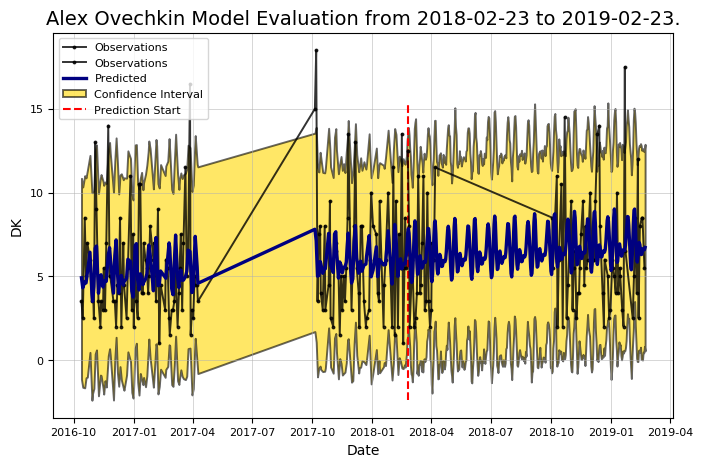

In [205]:
forecaster.evaluate_prediction()

Predicted Points on 2019-03-25 = 7.12


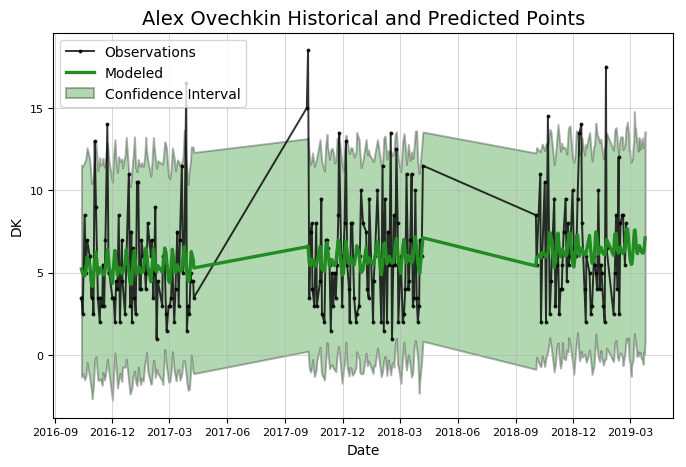

In [206]:
model, model_data = forecaster.create_prophet_model(days=30)

In [207]:
model_data[model_data['ds'] > '2019-02-23']

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
225,2019-02-24,6.558982,6.558982,6.558982,0.876205,13.862444,1.094623,1.094623,1.094623,1.094623,1.094623,1.094623,0.0,0.0,0.0,7.653605
226,2019-02-25,6.560553,6.560553,6.560553,0.796402,14.145298,1.116443,1.116443,1.116443,1.116443,1.116443,1.116443,0.0,0.0,0.0,7.676996
227,2019-02-26,6.562124,6.562124,6.562124,1.061527,13.688720,0.805291,0.805291,0.805291,0.805291,0.805291,0.805291,0.0,0.0,0.0,7.367415
228,2019-02-27,6.563696,6.563696,6.563696,0.301717,13.444796,0.305174,0.305174,0.305174,0.305174,0.305174,0.305174,0.0,0.0,0.0,6.868869
229,2019-02-28,6.565267,6.565267,6.565267,-0.389906,12.398301,-0.199758,-0.199758,-0.199758,-0.199758,-0.199758,-0.199758,0.0,0.0,0.0,6.365509
230,2019-03-01,6.566838,6.566838,6.566838,-0.297540,12.432525,-0.603056,-0.603056,-0.603056,-0.603056,-0.603056,-0.603056,0.0,0.0,0.0,5.963782
231,2019-03-02,6.568410,6.568410,6.568410,-1.039464,11.692919,-0.890012,-0.890012,-0.890012,-0.890012,-0.890012,-0.890012,0.0,0.0,0.0,5.678398
232,2019-03-03,6.569981,6.569981,6.569981,-1.267751,11.713121,-1.055034,-1.055034,-1.055034,-1.055034,-1.055034,-1.055034,0.0,0.0,0.0,5.514947
233,2019-03-04,6.571552,6.571552,6.571552,-0.547033,11.933486,-1.030544,-1.030544,-1.030544,-1.030544,-1.030544,-1.030544,0.0,0.0,0.0,5.541008
234,2019-03-05,6.573124,6.573124,6.573124,-0.454394,11.871044,-0.723384,-0.723384,-0.723384,-0.723384,-0.723384,-0.723384,0.0,0.0,0.0,5.849739


start_date=2016-10-13 00:00:00 end_date=2019-02-23 00:00:00
end_in=True start_in=True
Maximum CORE = 16.00 on 2017-10-07.
Minimum CORE = 0.00 on 2017-02-09.
Current CORE = 7.00 on 2019-02-23.



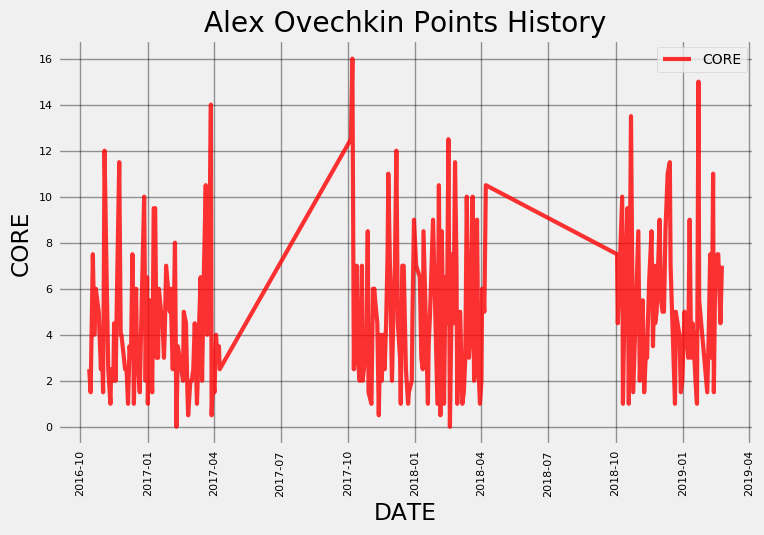

In [208]:
forecaster.plot_points()

start_date=2016-10-13 00:00:00 end_date=2019-02-23 00:00:00
end_in=True start_in=True
Maximum G = 4.00 on 2017-10-07.
Minimum G = 0.00 on 2016-10-13.
Current G = 1.00 on 2019-02-23.

Maximum A = 3.00 on 2017-10-28.
Minimum A = 0.00 on 2016-10-13.
Current A = 0.00 on 2019-02-23.

Maximum S = 11.00 on 2017-03-21.
Minimum S = 0.00 on 2017-02-09.
Current S = 8.00 on 2019-02-23.

Maximum DK = 18.50 on 2017-10-07.
Minimum DK = 1.00 on 2017-02-09.
Current DK = 8.00 on 2019-02-23.



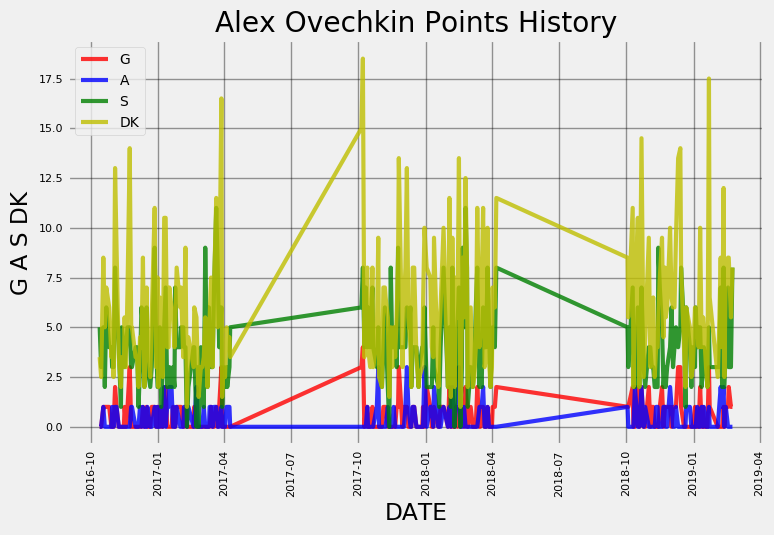

In [209]:
forecaster.plot_points(stats=['G', 'A', 'S', 'DK'], plot_type='basic')


Predicted Increase: 

          Date  estimate    change      upper     lower
225 2019-02-24  7.653605  0.342527  13.839092  0.980767
226 2019-02-25  7.676996  0.023391  14.448522  0.743326
233 2019-03-04  5.541008  0.026061  12.277335 -1.104881
234 2019-03-05  5.849739  0.308731  12.289515 -1.031438
235 2019-03-06  6.436492  0.586753  12.673061 -0.224506
236 2019-03-07  7.114481  0.677989  13.455901  0.585694
237 2019-03-08  7.579709  0.465228  14.155599  0.454361
238 2019-03-09  7.603292  0.023583  14.526619  1.195198
243 2019-03-14  6.351376  0.185059  12.611543  0.167754
244 2019-03-15  6.570500  0.219123  13.174604  0.031863
245 2019-03-16  6.647069  0.076569  12.776079  0.422162
251 2019-03-22  6.200188  0.003612  13.130854 -0.285637
252 2019-03-23  6.326250  0.126062  12.566007  0.029947
253 2019-03-24  6.647140  0.320891  12.988410  0.386110
254 2019-03-25  7.119478  0.472338  13.305547  1.187144

Predicted Decrease: 

          Date  estimate    change      upper     lower
22

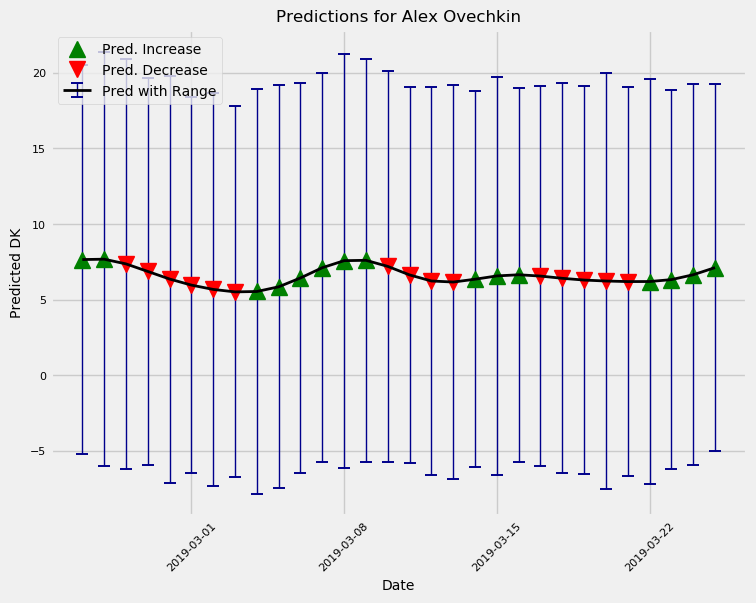

In [210]:
forecaster.predict_future()


Changepoints sorted by slope rate of change (2nd derivative):

          DATE   DK         delta
14  2016-11-15  3.0  1.103491e-11
64  2017-03-06  5.5  1.089916e-11
165 2018-10-04  5.5 -1.077039e-11
79  2017-04-05  4.5 -1.024999e-11
72  2017-03-23  5.0 -1.024310e-11


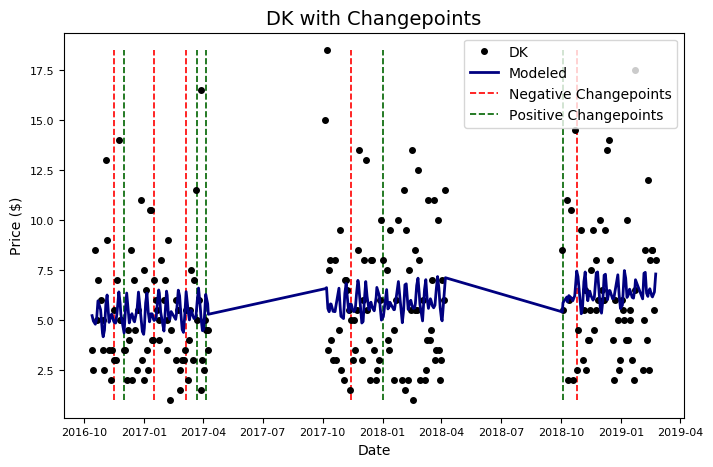

In [211]:
forecaster.growth = 'linear'
forecaster.changepoint_date_analysis()


Validation Range 2017-02-24 to 2018-02-22.

     cps  train_err  train_range  test_err  test_range
0  0.001   2.030885     9.718497  3.050700    9.663102
1  0.050   2.025034     9.974354  2.965095    9.944920
2  0.100   2.036797     9.800220  2.974210    9.810256
3  0.200   2.034582     9.809616  2.992812    9.774146
4  0.300   2.031777    10.003136  2.970548    9.933339
5  0.400   2.034860     9.947245  2.983118   10.012760
6  0.500   2.035946     9.959193  3.003360    9.984000
7  0.600   2.034609     9.908214  3.018160    9.957559
8  0.700   2.033513     9.903502  3.247367   10.091215


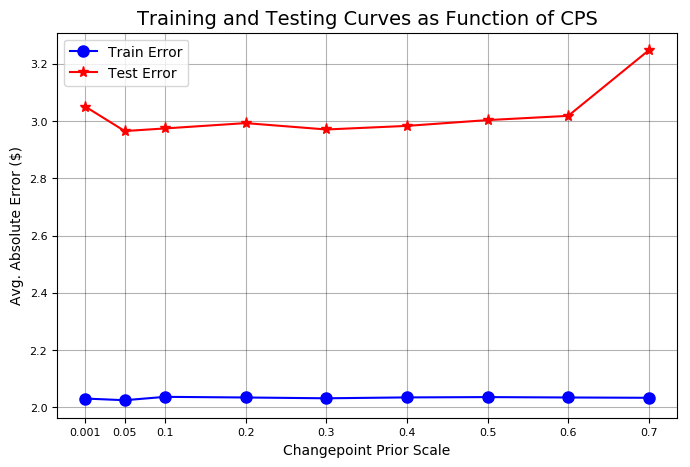

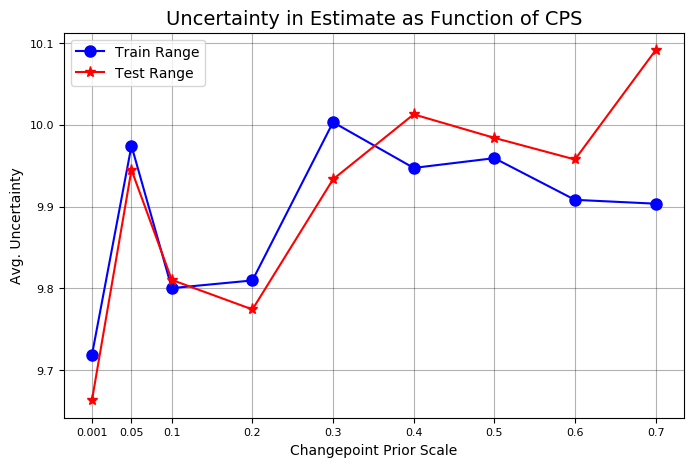

In [212]:
forecaster.changepoint_prior_validation(changepoint_priors=[0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])